In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv




## **1. LOADING LIBRARIES AND DATA**  <a class="anchor"  id="chapter1"></a>

## **1.1 Libraries** <a class="anchor"  id="subsection1"></a>

In [2]:
# Essentials
import numpy as np
import pandas as pd

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt

# Stats
import scipy.stats as stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from math import sqrt
from sklearn.metrics import mean_squared_error

# Models
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import Pool
from catboost import CatBoostRegressor
from sklearn.svm import SVR
from mlxtend.regressor import StackingCVRegressor

# Misc
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder, RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import make_pipeline

# Warnings
import warnings
warnings.filterwarnings('ignore')

## **1.2 Dataset** <a class="anchor"  id="subsection1"></a>

In [3]:
# Loading data
house_train=pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
house_test=pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

In [4]:
data_info=[(house_train.shape[0], house_train.shape[1]), 
           (house_test.shape[0], house_test.shape[1])]

data_shape=pd.DataFrame(data_info, columns=['Rows', 'Columns'], index=['Train', 'Test'])

print("*********************")
print("** DATA DIMENSIONS **")
print("*********************")
data_shape

*********************
** DATA DIMENSIONS **
*********************


,Rows,Columns
Train,1460,81
Test,1459,80


## **2. MANAGING DUPLICATES AND NULL VALUES**  <a class="anchor"  id="chapter2"></a>

## **2.1 Duplicates** <a class="anchor"  id="subsection1"></a>

In [5]:
def mostrar_duplicados(df):
    # Calcula la cantidad de duplicados
    duplicates = df.duplicated().sum()

In [6]:
dups_info=[{'Number of duplicates':mostrar_duplicados(house_train), 
            'Number of duplicates':mostrar_duplicados(house_test)}]

dups_info = pd.DataFrame(dups_info, index=['Train', 'Test'])

print("****************************")
print("** DUPLICATES INFORMATION **")
print("****************************")
dups_info

****************************
** DUPLICATES INFORMATION **
****************************


,Number of duplicates
Train,None
Test,None


## **2.2 Null values** <a class="anchor"  id="subsection2"></a>

## **Calculation** <a class="anchor"  id="subsection3"></a>

In [7]:
def nulls_values(df):
    df_nulls=pd.DataFrame(df.isna().sum(), columns=['Nulls'])
    df_nulls['Percentage (%)'] = (df_nulls['Nulls']/len(df))*100
    df_nulls=df_nulls[df_nulls['Nulls']>0].sort_values(by='Nulls', ascending=False)
    return df_nulls

In [8]:
print("***********************************")
print("** NULLS VALUES IN TRAIN DATASET **")
print("***********************************")

nulls_values(house_train).head(10)

***********************************
** NULLS VALUES IN TRAIN DATASET **
***********************************


,Nulls,Percentage (%)
PoolQC,1453,99.520548
MiscFeature,1406,96.301370
Alley,1369,93.767123
Fence,1179,80.753425
MasVnrType,872,59.726027
FireplaceQu,690,47.260274
LotFrontage,259,17.739726
GarageType,81,5.547945
GarageYrBlt,81,5.547945
GarageFinish,81,5.547945


In [9]:
print("**********************************")
print("** NULLS VALUES IN TEST DATASET **")
print("**********************************")

nulls_values(house_test).head(10)

**********************************
** NULLS VALUES IN TEST DATASET **
**********************************


,Nulls,Percentage (%)
PoolQC,1456,99.794380
MiscFeature,1408,96.504455
Alley,1352,92.666210
Fence,1169,80.123372
MasVnrType,894,61.274846
FireplaceQu,730,50.034270
LotFrontage,227,15.558602
GarageQual,78,5.346127
GarageCond,78,5.346127
GarageYrBlt,78,5.346127


In [10]:
train = house_train.drop(columns=["Id"])
test = house_test.drop(columns=["Id"])

## **Dealing with null values - training dataset** <a class="anchor"  id="subsection3"></a>

In [11]:
fill_with_NA=['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtExposure', 'BsmtFinType2', 'BsmtFinType1', 'BsmtCond', 'BsmtQual']
fill_with_mean=['LotFrontage', 'MasVnrArea', 'GarageYrBlt']
fill_with_mode=['MasVnrType', 'Electrical']

for i in fill_with_NA:
  train[i]=train[i].fillna("NA")

for i in fill_with_mean:
  train[i]=train[i].fillna(train[i].mean())

for i in fill_with_mode: 
  train[i]=train[i].fillna(train[i].value_counts().idxmax())

## **Dealing with null values - test dataset** <a class="anchor"  id="subsection3"></a>

In [12]:
fill_with_NA=['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtExposure', 'BsmtFinType2', 'BsmtFinType1', 'BsmtCond', 'BsmtQual']
fill_with_mean=['LotFrontage', 'MasVnrArea', 'GarageArea', 'TotalBsmtSF', 'BsmtUnfSF', 'BsmtFinSF2', 'BsmtFinSF1', 'GarageYrBlt', 'BsmtHalfBath', 'BsmtFullBath', 'GarageCars']
fill_with_mode=['MasVnrType', 'MSZoning', 'Functional', 'Utilities', 'KitchenQual', 'Exterior2nd', 'Exterior1st', 'SaleType']

for i in fill_with_NA:
  test[i]=test[i].fillna("NA")

for i in fill_with_mean:
  test[i]=test[i].fillna(test[i].mean())

for i in fill_with_mode: 
  test[i]=test[i].fillna(test[i].value_counts().idxmax())

## **Checking null values** <a class="anchor"  id="subsection3"></a>

In [13]:
print("***********************************")
print("** NULLS VALUES IN TRAIN DATASET **")
print("***********************************")

nulls_values(train).head(10)

***********************************
** NULLS VALUES IN TRAIN DATASET **
***********************************


,Nulls,Percentage (%)


In [14]:
print("**********************************")
print("** NULLS VALUES IN TEST DATASET **")
print("**********************************")

nulls_values(test).head(10)

**********************************
** NULLS VALUES IN TEST DATASET **
**********************************


,Nulls,Percentage (%)


## **3. ORDINAL ENCODING**  <a class="anchor"  id="chapter3"></a>

In [15]:
ordinal_label = ['LotShape', 'Utilities', 'LandSlope', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageFinish',
                'GarageQual', 'GarageCond', 'PoolQC', 'Fence']
ordinal_cats = [['Reg', 'IR1', 'IR2', 'IR3'], ['AllPub', 'NoSewr', 'NoSeWa', 'ELO'], ['Gtl', 'Mod', 'Sev'], ['Ex', 'Gd', 'TA', 'Fa', 'Po'], ['Ex', 'Gd', 'TA', 'Fa', 'Po'], ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'],
                ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'], ['Gd', 'Av', 'Mn', 'No', 'NA'], ['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf', 'NA'], ['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf', 'NA'], ['Ex', 'Gd', 'TA', 'Fa', 'Po'],
                ['Ex', 'Gd', 'TA', 'Fa', 'Po'], ['Typ', 'Min1', 'Min2', 'Mod', 'Maj1', 'Maj2', 'Sev', 'Sal'], ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'], ['Fin', 'RFn', 'Unf', 'NA'], ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'],
                ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'], ['Ex', 'Gd', 'TA', 'Fa', 'NA'], ['GdPrv', 'MnPrv', 'GdWo', 'MnWw', 'NA']]

In [16]:
oe = OrdinalEncoder(categories=ordinal_cats)
train[ordinal_label] = oe.fit_transform(train[ordinal_label])
test[ordinal_label] = oe.fit_transform(test[ordinal_label])

## **4. NEW FEATURES**  <a class="anchor"  id="chapter4"></a>

## **4.1 Training dataset** <a class="anchor"  id="subsection1"></a>

In [17]:
train['Porch_Area'] = (train[['OpenPorchSF','EnclosedPorch', '3SsnPorch', 'ScreenPorch']]).sum(axis=1)
train['Floor_Sq_Feet'] = (train[['1stFlrSF','2ndFlrSF']]).sum(axis=1)
train['OvrQuality'] = (train[['OverallQual','OverallCond']]).mean(axis=1)
train['ExtQuality'] = (train[['ExterQual','ExterCond']]).mean(axis=1)
train['Bath'] = (train[['FullBath','HalfBath']]).sum(axis=1)
train['BsmtBath'] = (train[['BsmtFullBath', 'BsmtHalfBath']]).sum(axis=1)
train['BsmtFinSF'] = train['TotalBsmtSF'] - train['BsmtUnfSF']
train['BsmtRating'] = (train[['BsmtFinType1','BsmtFinType2']]).mean(axis=1)
train['GarageQuality'] = (train[['GarageQual','GarageCond']]).mean(axis=1)

## **4.2 Test dataset** <a class="anchor"  id="subsection2"></a>

In [18]:
test['Porch_Area'] = (test[['OpenPorchSF','EnclosedPorch','3SsnPorch', 'ScreenPorch']]).sum(axis=1)
test['Floor_Sq_Feet'] = (test[['1stFlrSF','2ndFlrSF']]).sum(axis=1)
test['OvrQuality'] = (test[['OverallQual','OverallCond']]).mean(axis=1)
test['ExtQuality'] = (test[['ExterQual','ExterCond']]).mean(axis=1)
test['Bath'] = (test[['FullBath','HalfBath']]).sum(axis=1)
test['BsmtBath'] = (test[['BsmtFullBath', 'BsmtHalfBath']]).sum(axis=1)
test['BsmtFinSF'] = test['TotalBsmtSF'] - test['BsmtUnfSF']
test['BsmtRating'] = (test[['BsmtFinType1','BsmtFinType2']]).mean(axis=1)
test['GarageQuality'] = (test[['GarageQual','GarageCond']]).mean(axis=1)

## **4.3 Dropping features** <a class="anchor"  id="subsection3"></a>

In [19]:
vars_to_drop = ['OpenPorchSF','EnclosedPorch','3SsnPorch', '3SsnPorch', 'ScreenPorch', '1stFlrSF', '2ndFlrSF',
                'OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 'BsmtFullBath', 'BsmtHalfBath', 'TotalBsmtSF',
                'BsmtUnfSF', 'FullBath', 'HalfBath', 'GarageQual', 'GarageCond', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFinType1',
                'BsmtFinType2']

train=train.drop(vars_to_drop, axis=1)
test=test.drop(vars_to_drop, axis=1)

## **5. TARGET VISUALIZATION**  <a class="anchor"  id="chapter5"></a>

## **5.1 Pre-transformation** <a class="anchor"  id="subsection1"></a>

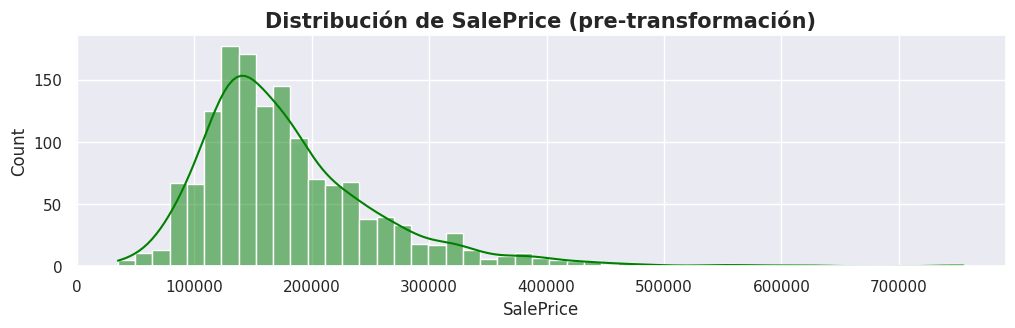

In [20]:
sns.set_theme()
plt.figure(figsize=(12,3))
sns.histplot(data=train , x=train['SalePrice'] , kde=True, color='green')
plt.title(f'Distribución de SalePrice (pre-transformación)', fontsize=15, fontweight='bold')
plt.show()

## **5.2 Post-transformation** <a class="anchor"  id="subsection2"></a>

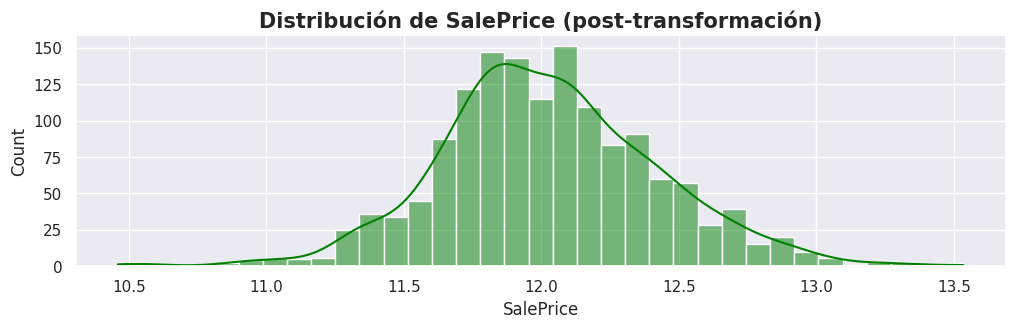

In [21]:
train['SalePrice']=np.log1p(train['SalePrice'])

sns.set_theme()
plt.figure(figsize=(12,3))
sns.histplot(data=train , x=train['SalePrice'] , kde=True, color='green')
plt.title(f'Distribución de SalePrice (post-transformación)', fontsize=15, fontweight='bold')
plt.show()

## **6. SKEWED FEATURES**  <a class="anchor"  id="chapter6"></a>

## **6.1 Training dataset** <a class="anchor"  id="subsection1"></a>

In [22]:
numeric_train=train.dtypes[train.dtypes != "object"].index
numeric_train=numeric_train.to_list()
numeric_train.remove("SalePrice")
numeric_train=pd.Index(numeric_train)
skewed_feats_train=train[numeric_train].apply(lambda x: skew(x)).sort_values(ascending=False)
skewness_train=pd.DataFrame({'Sesgo':skewed_feats_train})
skewness_train.head()

,Sesgo
Utilities,38.170678
MiscVal,24.451640
PoolArea,14.813135
LotArea,12.195142
LowQualFinSF,9.002080


In [23]:
high_skewness_train = skewness_train[skewness_train > 0.5]
high_skewness_values = high_skewness_train.index
skew_lambda = 0.15
for feat in high_skewness_values:
    train[feat] = boxcox1p(train[feat], skew_lambda)

## **6.2 Test dataset** <a class="anchor"  id="subsection2"></a>

In [24]:
numeric_test = test.dtypes[test.dtypes != "object"].index
skewed_feats_test = test[numeric_test].apply(lambda x: skew(x)).sort_values(ascending=False)
skewness_test = pd.DataFrame({'Sesgo':skewed_feats_test})
skewness_test.head()

,Sesgo
PoolArea,20.176117
MiscVal,20.054543
LowQualFinSF,16.150628
Functional,4.998586
LandSlope,4.963280


In [25]:
high_skewness_test = skewness_test[skewness_test > 0.5]
high_skewness_values2 = high_skewness_test.index
skew_lambda = 0.15
for feat in high_skewness_values2:
    test[feat] = boxcox1p(test[feat], skew_lambda)

## **7. FINAL DATASETS**  <a class="anchor"  id="chapter7"></a>

## **7.1 Training dataset** <a class="anchor"  id="subsection1"></a>

In [26]:
num_train_vars = list(train.select_dtypes(include=['float', 'int']))
cat_train_vars = list(train.select_dtypes(include=['object']))

train_num = train[num_train_vars]
train_cat = train[cat_train_vars]

train = pd.concat([train_num, train_cat], axis=1)
train.shape

(1460, 67)

## **7.2 Test dataset** <a class="anchor"  id="subsection2"></a>

In [27]:
num_test_vars = list(test.select_dtypes(include=['float', 'int']))
cat_test_vars = list(test.select_dtypes(include=['object']))

test_num = test[num_test_vars]
test_cat = test[cat_test_vars]

test = pd.concat([test_num, test_cat], axis=1)
test.shape

(1459, 66)

## **8. ONE-HOT ENCONDING**  <a class="anchor"  id="chapter8"></a>

In [28]:
# Introduction (I)
one_hot = ['MSZoning', 'Street', 'Alley', 'LandContour', 'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 
           'MasVnrType', 'Foundation', 'Heating', 'CentralAir', 'Electrical', 'GarageType', 'PavedDrive', 'MiscFeature', 'SaleType', 'SaleCondition']
train_test = pd.concat((train,test))
train_test.shape

(2919, 67)

In [29]:
# Introduction (II)
ohe = OneHotEncoder()
ohe.fit(train_test[one_hot])

OneHotEncoder()

## **8.1 Training dataset** <a class="anchor"  id="subsection1"></a>

In [30]:
encoded_data = ohe.transform(train[one_hot]).toarray()
onehot_train = pd.DataFrame(encoded_data, columns=ohe.get_feature_names_out(one_hot))
train = pd.concat([train, onehot_train], axis=1).drop(columns=one_hot)
train.shape

(1460, 214)

## **8.2 Test dataset** <a class="anchor"  id="subsection2"></a>

In [31]:
encoded_data2 = ohe.transform(test[one_hot]).toarray()
onehot_test = pd.DataFrame(encoded_data2, columns=ohe.get_feature_names_out(one_hot))
test = pd.concat([test, onehot_test], axis=1).drop(columns=one_hot)
test.shape

(1459, 213)

## **9. MODELLING**  <a class="anchor"  id="chapter9"></a>

## **9.1 Introduction** <a class="anchor"  id="subsection1"></a>

In [32]:
# VARIABLES INDEPENDIENTES
x = train.drop(['SalePrice'], axis = 1)

# VARIABLE OBJETIVO
y = train['SalePrice']

## **9.2 Cross-Validation** <a class="anchor"  id="subsection2"></a>

In [33]:
kf = KFold(n_splits=10 , shuffle=True, random_state=42)

def cv_rmse(model, x=x):
    rmse = np.sqrt(-cross_val_score(model, x, y, scoring="neg_mean_squared_error", cv=kf))
    return (rmse)

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

## **9.3 Models** <a class="anchor"  id="subsection3"></a>

In [34]:
#####################################
### Ridge, Lasso, ElasticNet, SVR ###
#####################################

alphas_ridge = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=alphas_ridge, cv=kf))

alphas_lasso = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
lasso = make_pipeline(RobustScaler(), LassoCV(max_iter=10000000, alphas=alphas_lasso, cv=kf))


alphas_elastic = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
l1ratio_elastic = [0.8, 0.85, 0.9, 0.95, 0.99, 1]
elasticnet = make_pipeline(RobustScaler(), ElasticNetCV(max_iter=10000000, alphas=alphas_elastic, l1_ratio=l1ratio_elastic, cv=kf))

svr = make_pipeline(RobustScaler(), SVR(C=20, epsilon=0.008, gamma=0.0003))


#################
### Light GBM ###
#################

lightgbm = make_pipeline(RobustScaler(),LGBMRegressor(objective='regression', num_leaves=4, learning_rate=0.01, n_estimators=9000, max_bin=200, 
                                                      bagging_fraction=0.75, bagging_freq=5, bagging_seed=7, feature_fraction=0.2, 
                                                      feature_fraction_seed=7, verbose=-1))

################
### Catboost ###
################

catboost= make_pipeline(RobustScaler(), CatBoostRegressor(iterations=6000, learning_rate=0.005, depth=4, l2_leaf_reg=1, eval_metric='RMSE',
                                                          early_stopping_rounds=200, verbose=False))

## **Model Scoring** <a class="anchor"  id="subsection4"></a>

In [35]:
score_ridge = cv_rmse(ridge)
score_lasso = cv_rmse(lasso)
score_elastic = cv_rmse(elasticnet)
score_svr = cv_rmse(svr)
score_lightgbm = cv_rmse(lightgbm)
score_catboost = cv_rmse(catboost)

scores=[score_ridge.mean(), score_lasso.mean(), score_elastic.mean(), score_svr.mean(), score_lightgbm.mean(), score_catboost.mean()]
stds=[score_ridge.std(), score_lasso.std(), score_elastic.std(), score_svr.std(), score_lightgbm.std(), score_catboost.std()]

## **Scoring Information** <a class="anchor"  id="subsection4"></a>

In [36]:
models=['Ridge', 'Lasso', 'ElasticNet', 'SVR', 'LightGBM', 'Catboost']

rmse_scores = {'RMSE': scores, 'Desviación': stds} 
rmse_scores_df = pd.DataFrame(rmse_scores, index=models)
rmse_scores_df

,RMSE,Desviación
Ridge,0.125990,0.024634
Lasso,0.123903,0.025329
ElasticNet,0.123694,0.025191
SVR,0.122883,0.027047
LightGBM,0.121370,0.016789
Catboost,0.117598,0.017633


## **Stacking** <a class="anchor"  id="subsection4"></a>

In [37]:
###############
### Stacked ###
###############

stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet, svr, lightgbm), meta_regressor=lightgbm, use_features_in_secondary=True)

## **Blending Models** <a class="anchor"  id="subsection4"></a>

In [38]:
elastic_model_full_data = elasticnet.fit(x, y)
lasso_model_full_data = lasso.fit(x, y)
ridge_model_full_data = ridge.fit(x, y)
svr_model_full_data = svr.fit(x, y)
lgb_model_full_data = lightgbm.fit(x, y)
catboost_model_full_data = catboost.fit(x, y)
stack_model_full_data = stack_gen.fit(np.array(x), np.array(y))

In [39]:
def blend_models_predict(x):
    return ((0.16 * catboost_model_full_data.predict(x)) + \
            (0.16 * lasso_model_full_data.predict(x)) + \
            (0.11 * ridge_model_full_data.predict(x)) + \
            (0.1 * svr_model_full_data.predict(x)) + \
            (0.2 * lgb_model_full_data.predict(x)) + \
            (0.27 * stack_model_full_data.predict(np.array(x))))

In [40]:
print('MODEL DEVIATION:')
print(rmsle(y, blend_models_predict(x)))

MODEL DEVIATION:
0.07893344299841797


## **CSV submission preparation** <a class="anchor"  id="subsection4"></a>

In [41]:
submission=pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv')

In [42]:
x_test=test.values
y_pred = (np.expm1(blend_models_predict(x_test)))

In [43]:
submission.iloc[:,1]=y_pred
submission.head(10)

,Id,SalePrice
0,1461,120011.211386
1,1462,156836.688186
2,1463,183546.277644
3,1464,196981.912588
4,1465,184201.757098
5,1466,171844.862488
6,1467,178028.568747
7,1468,166192.723361
8,1469,183819.829525
9,1470,122350.625459


In [44]:
submission.to_csv("submission_v6.csv", index=False)